In [73]:
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.TSLearner import *
from tqdm.autonotebook import tqdm
import scipy.stats
import scipy.special as sc

In [74]:
class UCB_Learner():
    def __init__(self, n_arms, arms, n_categories, ad_id):
        self. n_arms = n_arms
        self.n_categories = n_categories
        self.ad_id = ad_id
        self.reward_per_arm = np.zeros((n_categories, n_arms))
        self.empirical_mean = np.ones((n_categories, n_arms))
        self.confidence = np.ones((n_categories, n_arms))*np.inf
        self.count = np.zeros((n_categories, n_arms))
        self.collected_rewards = []
        self.t = 0
        self.c = 5.0  # exploration factor

    def pull_arm(self):
        ucb = self.empirical_mean+self.confidence
        pulled_arm = np.argmax(ucb, axis=-1)

        bids = [Bid(pulled_arm[i], self.ad_id) for i in range(5)]
        return bids

    def update(self, pulled_arm, reward):
        self.t += 1

        self.collected_rewards.append(reward)
        for i in range(self.n_categories):

            self.reward_per_arm[i][pulled_arm[i].bid] += reward[i]
            self.count[i][pulled_arm[i].bid] += 1

            self.empirical_mean[i][pulled_arm[i].bid
                                   ] = self.reward_per_arm[i][pulled_arm[i].bid]/self.count[i][pulled_arm[i].bid]
            # exploration factor
            self.confidence[i][pulled_arm[i].bid] = self.c*np.sqrt(
                2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
        for i in range(self.n_categories):
            self.empirical_mean[i][self.count[i] == 0] = np.inf
            self.confidence[i][self.count[i] == 0] = np.inf


In [75]:
def reward_control_allocation(best_allocation, ad_id, reward):
    temp=[]
    for i in range(5):
        control = False
        for j in range(len(best_allocation[i])):
            if (best_allocation[i][j].ad_id == ad_id):
                control = True
                break
        if control:
            # temp.append(reward)
            temp.append(reward)
        else:
            temp.append(0)
    return temp        


In [76]:
def test(n_test=1000,learner=None, vcg=None, social_network=None):
    collected_tot=[]
    rewards=[]
    for i in tqdm(range(n_test)):
        bids_adversaries = []
        for i in range(0, 5):
            bid_categoria = np.array([])
            for j in range(0, 10):  # numero di avversari
                bid = Bid(bid=random.randint(1, 4), id=j+3)
                bid_categoria = np.append(bid_categoria, bid)
            bids_adversaries.append(bid_categoria)

    # add the bid of the learner to our campain
    #pulled_arm_ts = ts_learner.pull_arm()
        pulled_arm= learner.pull_arm()
        for i in range(5):
        #bids_adversaries[i][0] = pulled_arm_ts[i]
          bids_adversaries[i][0] = pulled_arm[i]



        best_allocation = vcg.all_best_allocations(list_camp_bids=bids_adversaries, social_network=social_network)
    # ACTIVATE THE CASCADE OF OUR SOCIAL NETWORK AND COMPUTE THE REWARDS
        reward = activate_cascade(social_network=social_network,
                              ad_allocation_list=best_allocation, slot_prominence=lambdas)
    
    # with this part of code i set that if the learner is present in the allocation list then get the normal allocation
    # reward, if it's not present and it bids 0 then the reward is 0.
    #
    #temp_ts = reward_control_allocation(best_allocation, 1, reward)
        temp= np.array(reward_control_allocation(best_allocation,1, reward))

        payments= np.array(vcg.payments(bids_adversaries,best_allocation,social_network=social_network ))
 
    # updating of the learners
    #ts_learner.update(pulled_arm_ts, temp_ts)
        learner.update(pulled_arm, temp-payments)
        collected_tot.append(temp-payments)
            
        rewards.append(reward)
    plt.figure(0)
    plt.plot(np.array(np.mean(collected_tot,axis=-1)), 'r')
    plt.show()


100%|██████████| 1000/1000 [00:05<00:00, 196.34it/s]


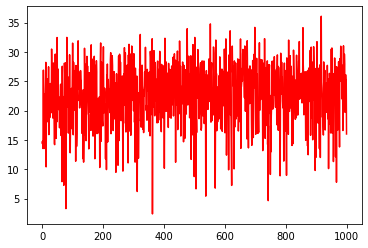

  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-74-dbbf73817faa>:34: RuntimeWarning: invalid value encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
<ipython-input-74-dbbf73817faa>:34: RuntimeWarning: divide by zero encountered in double_scalars
  2*np.log(self.t)/(self.count[i][pulled_arm[i].bid]-1))
100%|██████████| 1000/1000 [00:05<00:00, 182.63it/s]


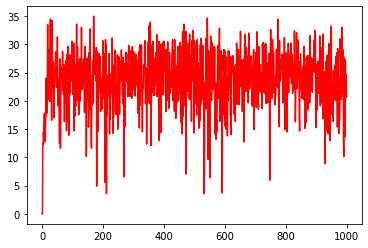

In [77]:
#setting of the environment for the test
prev_reward = 0
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')
lambdas = [0.9, 0.75, 0.7, 0.40, 0.35, 0.20]
arms = [0, 1, 2, 3, 4]
vcg = VCG()

random.seed(1234)


ts_learner = TS_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
ucb_learner = UCB_Learner(n_arms=len(arms), arms=arms, n_categories=5, ad_id=1)
test(1000, ts_learner, vcg, social_network)
test(1000, ucb_learner,vcg, social_network)

In [78]:
print(ucb_learner.empirical_mean)
print(ucb_learner.confidence)
print(ucb_learner.count)

[[ 0.          0.         18.65142857 20.68668099 23.94221074]
 [ 0.         15.46        0.         24.20328764 23.38225641]
 [ 0.         15.62       11.41333333 23.29011048 24.06044156]
 [ 0.          0.         16.11085714 19.65391941 23.93376278]
 [ 0.         15.3         0.         21.8517605  24.02035677]]
[[5.88705011 8.32554611 4.85902369 3.7112627  0.5976408 ]
 [5.88705011 6.43545731 9.46509236 0.65871407 1.19335066]
 [5.88705011 8.32554611 8.00772964 1.11555878 0.67017821]
 [5.88705011 8.32554611 5.95106434 4.60694684 0.59457438]
 [5.88705011 8.32554611 9.46509236 2.64798787 0.6023307 ]]
[[  2.   2.   7.  21. 968.]
 [  2.   4.   2. 797. 195.]
 [  2.   2.   3. 223. 770.]
 [  2.   2.   5.  13. 978.]
 [  2.   2.   2.  41. 953.]]


In [79]:
ts_learner.pull_arm()

[(bid=4, id=1), (bid=4, id=1), (bid=4, id=1), (bid=4, id=1), (bid=4, id=1)]

In [80]:
ucb_learner.pull_arm()

[(bid=4, id=1), (bid=3, id=1), (bid=4, id=1), (bid=4, id=1), (bid=4, id=1)]